<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Stratification" data-toc-modified-id="Stratification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Stratification</a></span><ul class="toc-item"><li><span><a href="#Experiments" data-toc-modified-id="Experiments-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Experiments</a></span><ul class="toc-item"><li><span><a href="#Same-expectation-and-variance" data-toc-modified-id="Same-expectation-and-variance-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Same expectation and variance</a></span></li><li><span><a href="#Different-expectation-Same-variance" data-toc-modified-id="Different-expectation-Same-variance-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Different expectation Same variance</a></span></li><li><span><a href="#Different-expectation-and-variance" data-toc-modified-id="Different-expectation-and-variance-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Different expectation and variance</a></span></li></ul></li></ul></li></ul></div>

# Stratification

In [1]:
%matplotlib inline

In [2]:
import os
from functools import reduce
from operator import mul
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

In [3]:
def generate_distributions(means, sigmas, strat_coefficients, V=10000):
    assert sum(strat_coefficients) == 1
    parts = np.round(V * strat_coefficients).astype(int)
    return [np.random.normal(m, s, k) for m, s, k in zip(means, sigmas, parts)]


def get_optimal_sample_coefficients(distributions, strat_coefficients, sample_size):
    _sigmas = np.array([np.std(dist) for dist in distributions])
    mul_pairs = _sigmas * strat_coefficients
    return np.round(sample_size * mul_pairs / sum(mul_pairs)).astype(int)


def get_proportional_sample_coefficients(strat_coefficients, sample_size):
    return np.round(sample_size * strat_coefficients).astype(int)


def get_sample(distributions, ns):
    return np.concatenate([np.random.choice(dist, size) for dist, size in zip(distributions, ns)])


def get_samples(distributions, proportional_n, optimal_n):
    # simple
    yield np.random.choice(np.concatenate(distributions), sum(optimal_n))
    
    # proportional 
    yield get_sample(distributions, proportional_n)

    # optimal
    yield get_sample(distributions, optimal_n)

    
def update_result_dict(result_dict, res):
    result_dict['simple_mean'].append(res[0][0])
    result_dict['simple_var'].append(res[0][1])

    result_dict['proportional_mean'].append(res[1][0])
    result_dict['proportional_var'].append(res[1][1])

    result_dict['optimal_mean'].append(res[2][0])
    result_dict['optimal_var'].append(res[2][1])

    
def experiment(distributions, proportional_n, optimal_n):    
    return [(np.mean(sample), np.var(sample)) for sample in get_samples(distributions, proportional_n, optimal_n)]
    
    
def run_experiment(sample_size, means, sigmas, strat_coefficients, retry=1000):
    distributions = generate_distributions(means, sigmas, strat_coefficients)
    
    proportional_n = get_proportional_sample_coefficients(strat_coefficients, sample_size)
    display('proportional_n = {}'.format(proportional_n))

    optimal_n = get_optimal_sample_coefficients(distributions, strat_coefficients, sample_size)
    display('optimal_n = {}'.format(optimal_n))

    result = defaultdict(list)
    for _ in tqdm(range(retry)):
        update_result_dict(result, experiment(distributions, proportional_n, optimal_n))

    real_mean = sum(means * strat_coefficients)
    # real_var = sum((sigmas ** 2) * strat_coefficients) + sum(((real_mean - means) ** 2) * strat_coefficients)
        
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    axs[0].boxplot([result['simple_mean'], result['proportional_mean'], result['optimal_mean']])
    axs[0].set_title('mean')
    axs[0].set_xticklabels(['simple', 'proportional', 'optimal'], fontsize=14)
    axs[0].plot(range(5), np.repeat(real_mean, 5), label='mean')
    # legend = axs[0].legend(loc='upper center', fontsize='x-large')

    axs[1].boxplot([result['simple_var'], result['proportional_var'], result['optimal_var']])
    axs[1].set_title('var')
    axs[1].set_xticklabels(['simple', 'proportional', 'optimal'], fontsize=14)
    return result 

## Experiments

### Same expectation and variance

В процессе моделирования, из генеральной совокупности случайной величины (являющейся смесью трёх нормально распределённых случайных величин) извлекались выборки объма 40 и 500 тремя различными способами:

* Прстое случайное сэмплирование
* Пропорциональное сэмплирвоание
* Оптимальное сэмплирвоание

По извлечённым выборкам строились оценки математического ожидания и дисперсии исследуемой случайной величины. Эксперимент повторялся 1000 раз, и по результатам серии экспериментов сравнивались характеристики получившихся оценок.

In [4]:
MEANS=np.array([0.0, 0.0, 0.0])
SIGMAS=np.array([1.0, 1.0, 1.0])
STRAT_COEFFICIENTS=np.array([0.5, 0.2, 0.3])
sum(STRAT_COEFFICIENTS)

1.0

'proportional_n = [20  8 12]'

'optimal_n = [20  8 12]'

100%|██████████| 1000/1000 [00:00<00:00, 3425.97it/s]


'РаВные мат ожидания и РаВные дисперсии | V = 40'

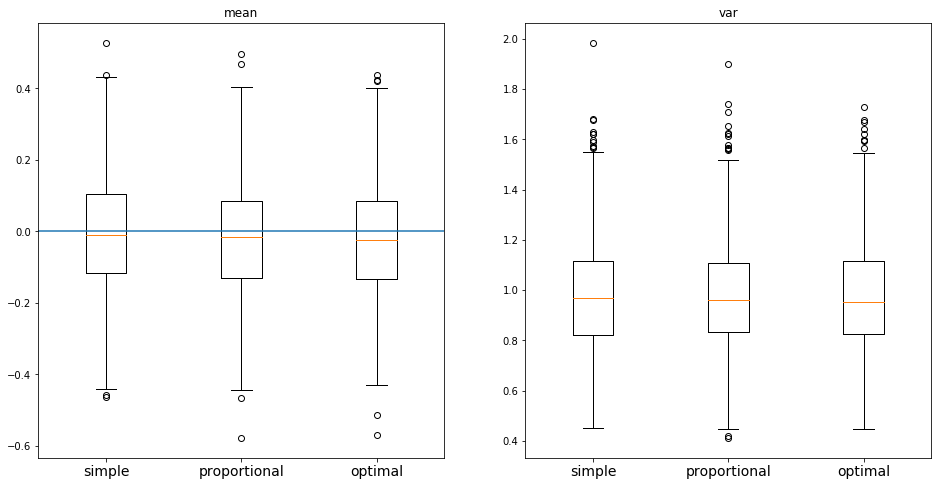

In [5]:
run_experiment(40, means=MEANS, sigmas=SIGMAS, strat_coefficients=STRAT_COEFFICIENTS)
display('РаВные мат ожидания и РаВные дисперсии | V = 40')

'proportional_n = [250 100 150]'

'optimal_n = [252  98 150]'

100%|██████████| 1000/1000 [00:00<00:00, 2841.33it/s]


'РаВные мат ожидания и РаВные дисперсии V = 500'

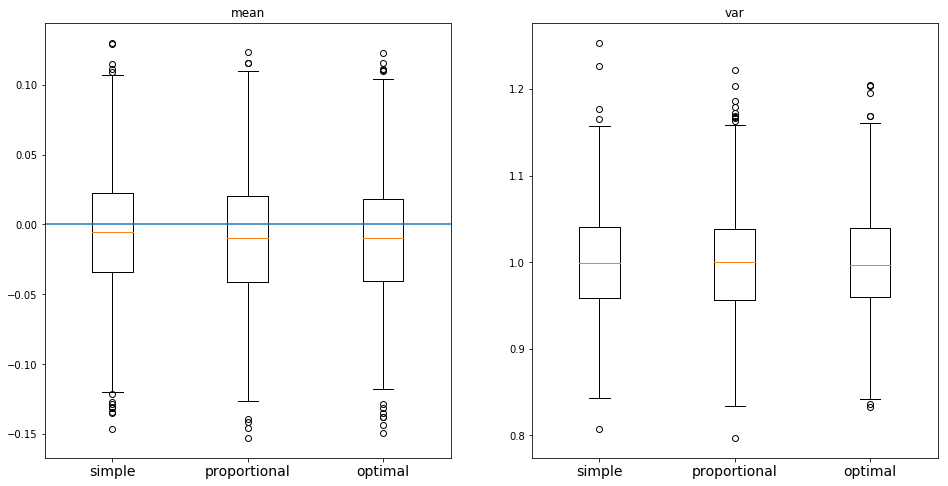

In [6]:
run_experiment(500, means=MEANS, sigmas=SIGMAS, strat_coefficients=STRAT_COEFFICIENTS)
display('РаВные мат ожидания и РаВные дисперсии V = 500')

По результатам моделирования можно сделать следующие выводы: 
В случае одинаковых мат ожиданий и дисперсий оценка мат ожидания, полученная любым из способов является несмещённой, в то время как оценка дисперсии получилась смещённая для всех способов (?? противоречит лекции). С увеличением объёма выборки оценка построенаая по без стратификации прилижается к той, что получена с учётом стратификации, однако остаётся смещённой относительно настоящего значения. 

Разброс оценок мат ожидания квартили и интерквартильный разброс практически совпадают, независимо от метода. Для оценок дисперсии ситуации аналогична. 

Таким образом, в данном случае применение стратификации - нецелесообразно.

### Different expectation Same variance

In [7]:
MEANS=np.array([5.0, 2.0, 0.0])

In [8]:
# run_experiment(40, means=MEANS, sigmas=SIGMAS, strat_coefficients=STRAT_COEFFICIENTS)
# display('РаЗные мат ожидания и РаВные дисперсии | V = 40')

In [9]:
# run_experiment(500, means=MEANS, sigmas=SIGMAS, strat_coefficients=STRAT_COEFFICIENTS)
# display('РаЗные мат ожидания и РаВные дисперсии | V = 500')

По результатам моделирования можно сделать следующие выводы: 


### Different expectation and variance

In [10]:
SIGMAS=np.array([0.5, 1.0, 2.0])

'proportional_n = [20  8 12]'

'optimal_n = [ 9  8 23]'

100%|██████████| 1000/1000 [00:00<00:00, 3427.39it/s]


'РаЗные мат ожидания и РаЗные дисперсии | V = 40'

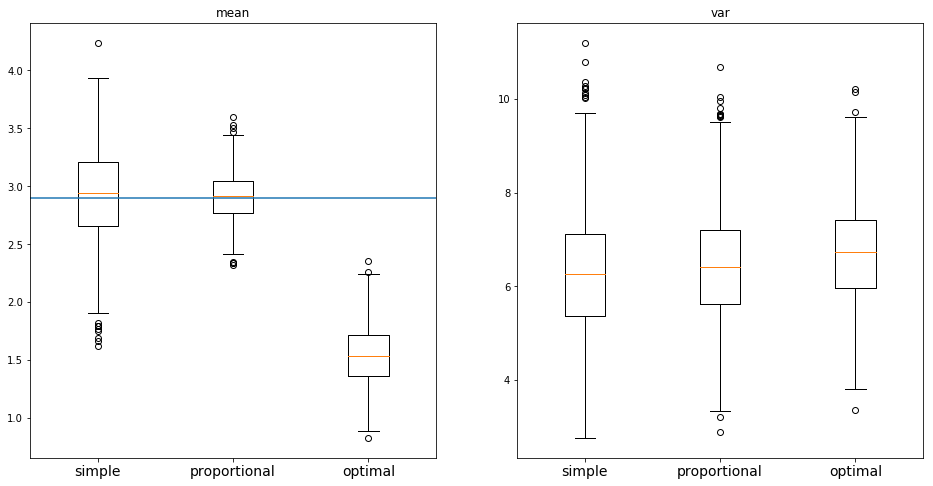

In [11]:
run_experiment(40, means=MEANS, sigmas=SIGMAS, strat_coefficients=STRAT_COEFFICIENTS)
display('РаЗные мат ожидания и РаЗные дисперсии | V = 40')

'proportional_n = [250 100 150]'

'optimal_n = [119  93 287]'

100%|██████████| 1000/1000 [00:00<00:00, 2727.33it/s]


'РаЗные мат ожидания и РаЗные дисперсии | V = 500'

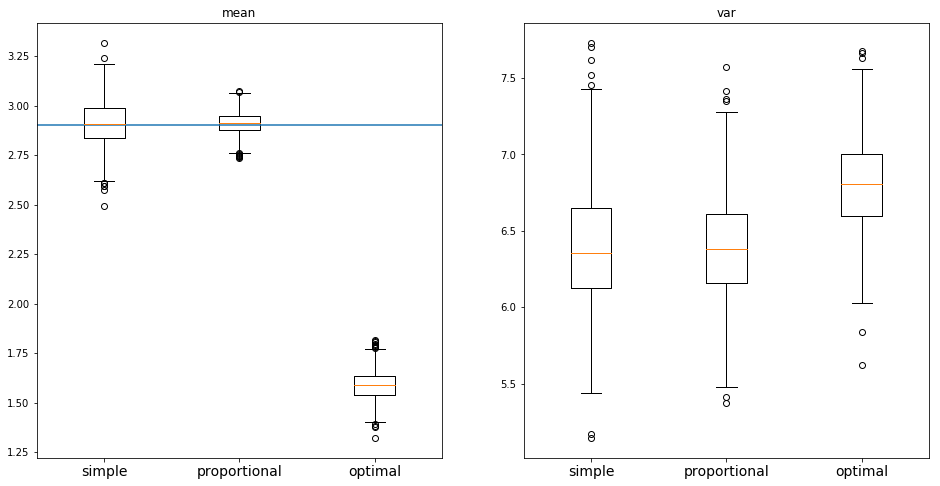

In [12]:
run_experiment(500, means=MEANS, sigmas=SIGMAS, strat_coefficients=STRAT_COEFFICIENTS)
display('РаЗные мат ожидания и РаЗные дисперсии | V = 500')

Вот здесь я получаю очень сильное смещение в оценке среднего и рост дисперсии в случае **оптимального** сэмплирвоания. 

Однако этот метод сэмплирования должен давать противоположный результат. В то же время я не вижу ничего неожиданного в результатах, ведь согласно формуле мы будем брать больше точек из той страты, дисперсия которой больше. Вот и получается что  мы тянем больше из последней, смещая таким образом оценку мат ожидания в сторону актуального для третьей страты значения мат ожидания. 